### 1. Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('Mall_Customers.csv')
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
data = df[features].values

data_min = data.min(axis=0)
data_max = data.max(axis=0)
data_norm = (data - data_min) / (data_max - data_min)

### 2. SOM Implementation

In [3]:
class SOM:
    def __init__(self, height, width, input_dim, sigma_start, sigma_end, lr, epochs):
        self.height = height
        self.width = width
        self.input_dim = input_dim
        self.sigma_start = sigma_start
        self.sigma_end = sigma_end
        self.lr = lr
        self.epochs = epochs
        
        np.random.seed(42)
        self.weights = np.random.rand(height, width, input_dim)
        
        self.grid_coords = np.zeros((height, width, 2))
        for i in range(height):
            for j in range(width):
                self.grid_coords[i, j] = [i, j]

    def _get_bmu(self, vector):
        diff = self.weights - vector
        sq_dist = np.sum(diff**2, axis=2)
        bmu_idx = np.unravel_index(np.argmin(sq_dist), (self.height, self.width))
        return bmu_idx

    def train(self, data):
        num_samples = data.shape[0]
        
        for epoch in range(self.epochs):
            sigma = self.sigma_start + (epoch / self.epochs) * (self.sigma_end - self.sigma_start)
            current_lr = self.lr
            
            indices = np.random.permutation(num_samples)
            
            for idx in indices:
                sample = data[idx]
                bmu_idx = self._get_bmu(sample)
                
                grid_dist_sq = np.sum((self.grid_coords - self.grid_coords[bmu_idx])**2, axis=2)
                h = np.exp(-grid_dist_sq / (2 * sigma**2)) 
                
                h_expanded = h[:, :, np.newaxis]
                self.weights += current_lr * h_expanded * (sample - self.weights)

    def get_clusters(self, data):
        clusters = []
        for sample in data:
            bmu_idx = self._get_bmu(sample)
            clusters.append(bmu_idx[0] * self.width + bmu_idx[1]) 
        return np.array(clusters)

    def get_bmu_coords(self, data):
        """Get 2D coordinates of BMU for each sample."""
        coords = []
        for sample in data:
            coords.append(self._get_bmu(sample))
        return np.array(coords)

### 3. Fit

In [4]:
h, w = 4, 2
sigma_start = 2.5
sigma_end = 1.0
lr = 0.5

som_100 = SOM(h, w, 3, sigma_start, sigma_end, lr, 100)
som_100.train(data_norm)
clusters_100 = som_100.get_clusters(data_norm)

som_1000 = SOM(h, w, 3, sigma_start, sigma_end, lr, 1000)
som_1000.train(data_norm)
clusters_1000 = som_1000.get_clusters(data_norm)

### 4. Plot

Results for 100 Epochs:


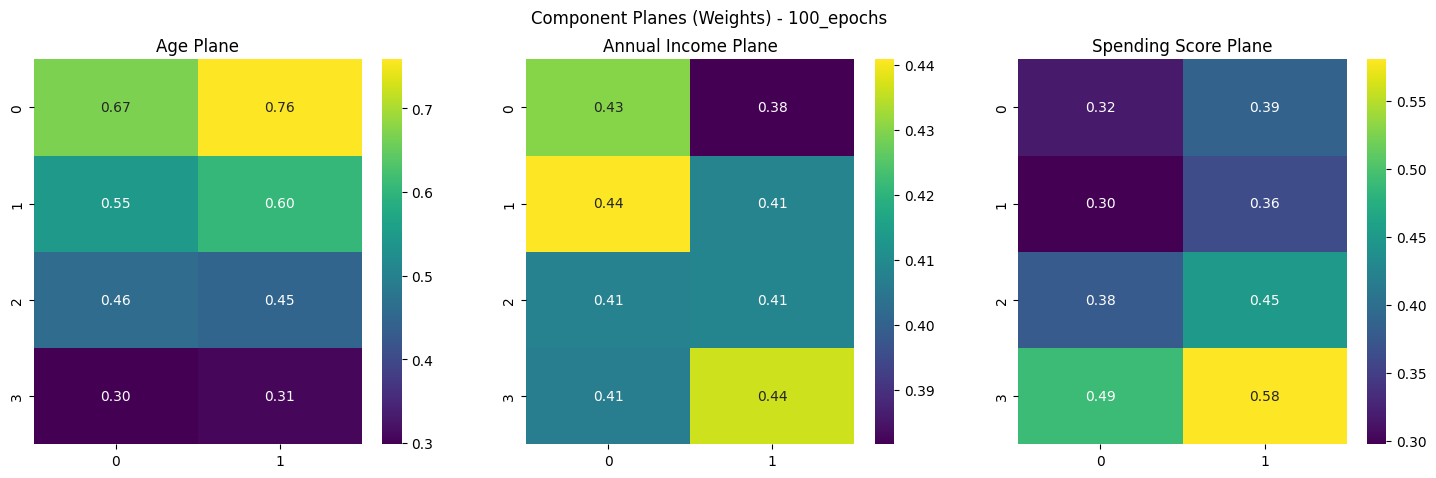

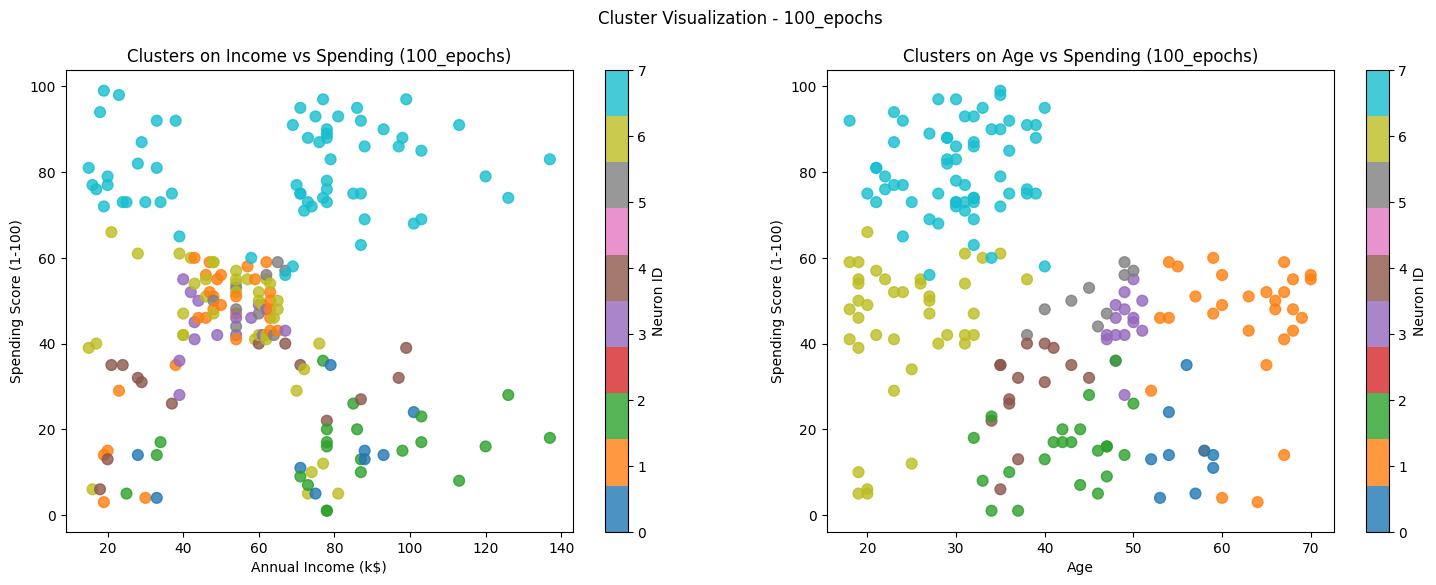

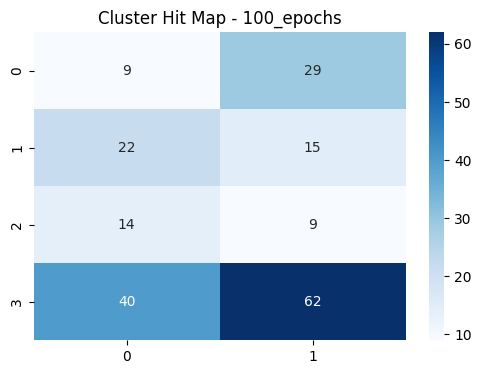


Results for 1000 Epochs:


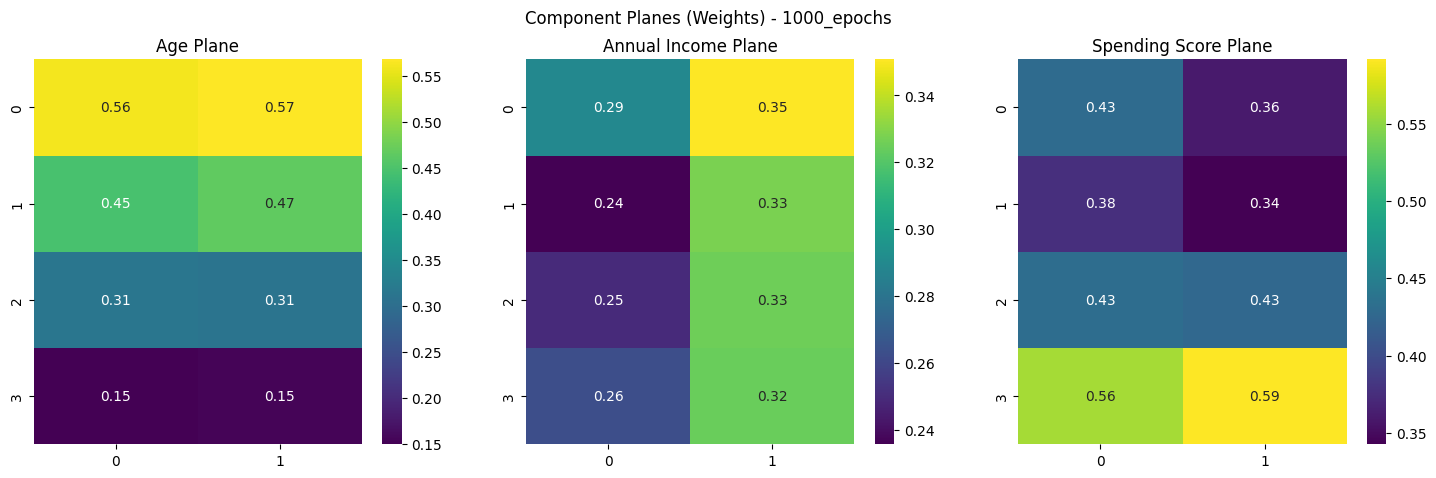

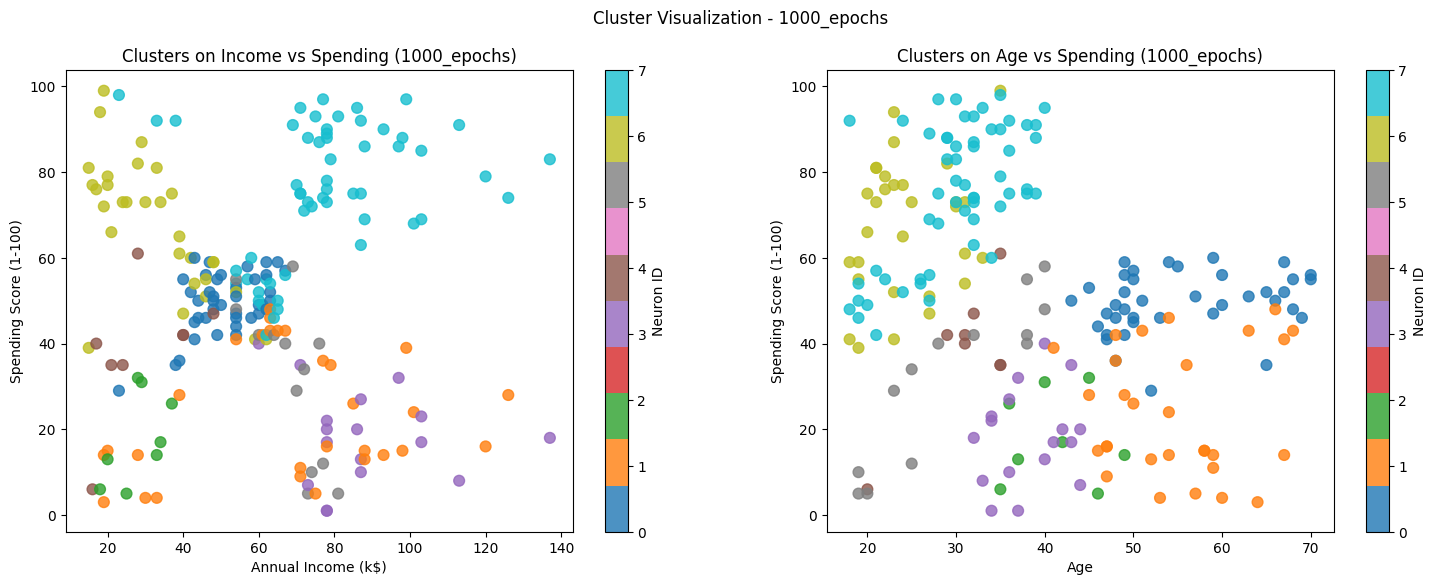

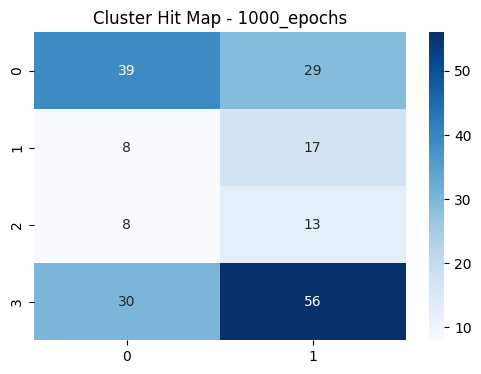

In [5]:
def plot_som_results(som, clusters, data, title_suffix, original_data):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    feature_names = ['Age', 'Annual Income', 'Spending Score']
    
    for i in range(3):
        weight_plane = som.weights[:, :, i]
        sns.heatmap(weight_plane, ax=axes[i], cmap='viridis', annot=True, fmt=".2f")
        axes[i].set_title(f'{feature_names[i]} Plane')
    
    plt.suptitle(f'Component Planes (Weights) - {title_suffix}')
    plt.savefig(f'component_planes_{title_suffix}.png')
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    scatter = axes[0].scatter(original_data[:, 1], original_data[:, 2], c=clusters, cmap='tab10', s=60, alpha=0.8)
    axes[0].set_xlabel('Annual Income (k$)')
    axes[0].set_ylabel('Spending Score (1-100)')
    axes[0].set_title(f'Clusters on Income vs Spending ({title_suffix})')
    plt.colorbar(scatter, ax=axes[0], label='Neuron ID')

    scatter2 = axes[1].scatter(original_data[:, 0], original_data[:, 2], c=clusters, cmap='tab10', s=60, alpha=0.8)
    axes[1].set_xlabel('Age')
    axes[1].set_ylabel('Spending Score (1-100)')
    axes[1].set_title(f'Clusters on Age vs Spending ({title_suffix})')
    plt.colorbar(scatter2, ax=axes[1], label='Neuron ID')
    
    plt.suptitle(f'Cluster Visualization - {title_suffix}')
    plt.savefig(f'clusters_scatter_{title_suffix}.png')
    plt.show()
    
    hits = np.zeros((som.height, som.width))
    bmu_coords = som.get_bmu_coords(data)
    for r, c in bmu_coords:
        hits[r, c] += 1
        
    plt.figure(figsize=(6, 4))
    sns.heatmap(hits, annot=True, fmt='g', cmap='Blues')
    plt.title(f'Cluster Hit Map - {title_suffix}')
    plt.savefig(f'hit_map_{title_suffix}.png')
    plt.show()

print("Results for 100 Epochs:")
plot_som_results(som_100, clusters_100, data_norm, '100_epochs', df[features].values)

print("\nResults for 1000 Epochs:")
plot_som_results(som_1000, clusters_1000, data_norm, '1000_epochs', df[features].values)